In [1]:
import os
import sys

top_dir = os.path.split(os.getcwd())[0]
sys.path.append(top_dir)
sys.path.append(os.path.join(top_dir, "src"))

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import seaborn as sns
from yaml import safe_load

%load_ext lab_black

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


In [3]:
def autolabel(ax, orient="h", fmt="{:,f}", xytext=(5, -4), **kwargs):
    """Automatically labels the rectangles in a (vertical) bar chart.
    """

    for rect in ax.patches:
        if orient == "h":
            size = rect.get_width()
            xy = (size, rect.get_y())
        else:
            size = rect.get_height()
            xy = (rect.get_x() + rect.get_width() / 2, size)
        if size != 0:
            ax.annotate(
                fmt.format(size),
                xy=xy,
                xytext=xytext,
                textcoords="offset points",
                ha="center",
                va="bottom",
                **kwargs,
            )


def get_colnames(genres, metric_names):
    return [f"{name}_{genre}" for name in metric_names for genre in genres]


def build_df(results, metric_names):
    genres = results[metric_names[0]].keys()
    per_metric_dfs = []
    for genre in genres:
        per_genre_dfs = []
        for metric in metric_names:
            df = pd.DataFrame(np.array(results[metric][genre]), columns=["value"])
            df["metric"] = metric
            df["model"] = genre
            per_genre_dfs.append(df)
        per_metric_dfs.append(pd.concat(per_genre_dfs, axis=0))

    return pd.concat(per_metric_dfs, axis=0)[["model", "metric", "value"]]

In [13]:
# models were trained during 14th/15th of July
models = [m for m in os.listdir("../trained_models") if "07_15" in m or "07_14" in m]

# Create a map between the model train dir and the training configuration
name_map = {}
for model in models:
    base = model.split("_")[0]
    with open(f"../trained_models/{model}/train_config.yaml") as f:
        config = safe_load(f)
        fs = config["preprocessing"]["fs"]
        n_bars = config["preprocessing"]["n_bars"]
        name_map[model] = f"{base}_fs{fs}_{n_bars}bars"

In [17]:
results_fpath = "../results/bodhidharma"
nano_df = []
macro_df = []
tonnetz_df = []

# Load the results
for model_name in os.listdir(results_fpath):
    fname = os.listdir(os.path.join(results_fpath, model_name))[0]
    fpath = os.path.join(results_fpath, model_name, fname)

    with open(fpath, "r") as f:
        results = json.load(f)

    # Create dataframes
    chromas = build_df(results, ["chroma_similarities"])
    tonnetz_distances = build_df(results, ["tonnetz_distances"])
    style_macro = build_df(results, ["macro_time_pitch_diff", "macro_onset_duration"])
    style_per_song = build_df(
        results, ["per_song_time_pitch_diff", "per_song_onset_duration"]
    )

    nano_metrics = pd.concat([chromas, style_per_song], axis=0)
    nano_metrics["model_name"] = name_map.get(model_name)
    tonnetz_distances["model_name"] = name_map.get(model_name)
    style_macro["model_name"] = name_map.get(model_name)

    nano_df.append(nano_metrics[nano_metrics["model_name"].notna()])
    tonnetz_df.append(tonnetz_distances[tonnetz_distances["model_name"].notna()])
    macro_df.append(style_macro[style_macro["model_name"].notna()])

nano_df = pd.concat(nano_df, axis=0)
tonnetz_df = pd.concat(tonnetz_df, axis=0)
macro_df = pd.concat(macro_df, axis=0)

In [19]:
nano_df.head()

,model,metric,value,model_name
0,Modern Pop2Jazz,chroma_similarities,0.341077,jazz_fs8_1bars
1,Modern Pop2Jazz,chroma_similarities,0.259960,jazz_fs8_1bars
2,Modern Pop2Jazz,chroma_similarities,0.308632,jazz_fs8_1bars
3,Modern Pop2Jazz,chroma_similarities,0.256807,jazz_fs8_1bars
4,Modern Pop2Jazz,chroma_similarities,0.256368,jazz_fs8_1bars


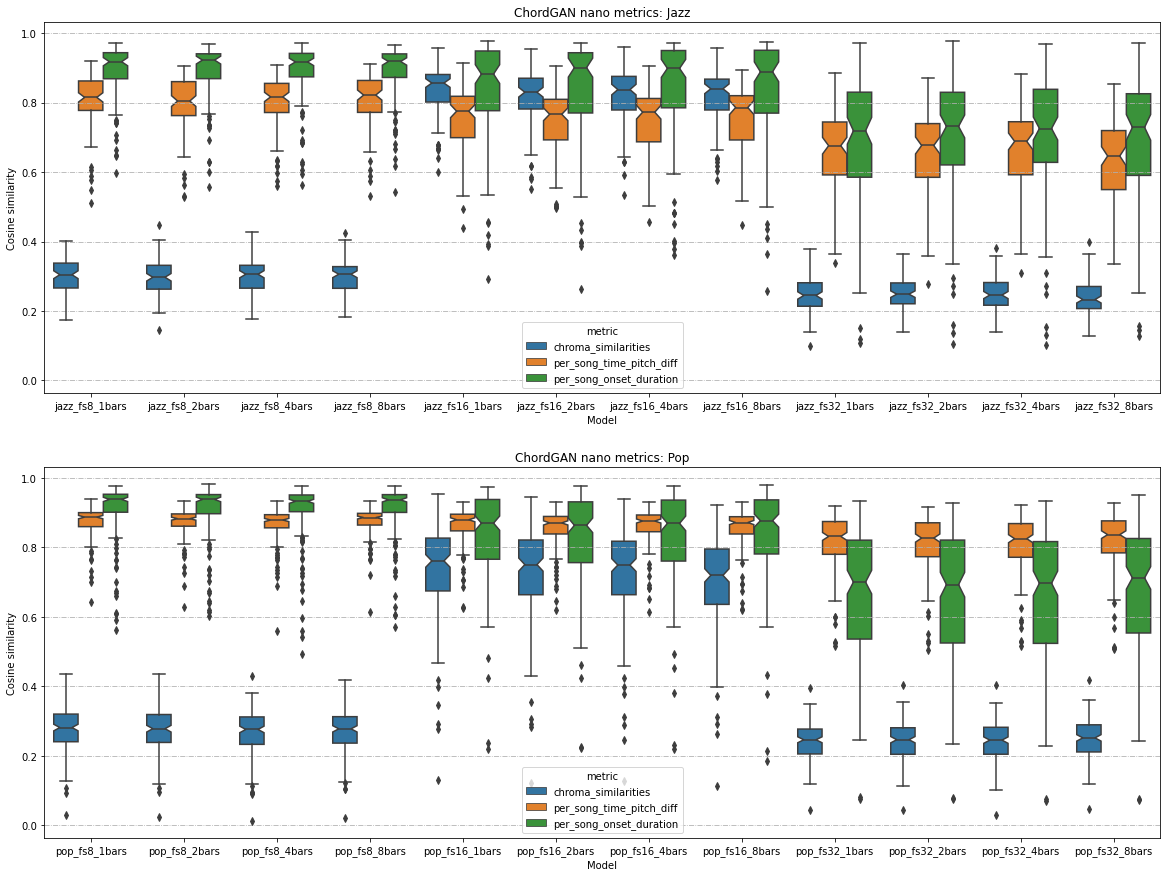

In [24]:
from matplotlib.ticker import MultipleLocator, AutoMinorLocator

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 15), sharey=True)

nano_jazz = nano_df[nano_df["model_name"].str.contains("jazz")]
nano_pop = nano_df[nano_df["model_name"].str.contains("pop")]

ax1 = sns.boxplot(
    x="model_name", y="value", hue="metric", data=nano_jazz, ax=ax1, notch=True
)
ax1.yaxis.grid(True, linestyle="-.")
ax1.set_title("ChordGAN nano metrics: Jazz")
ax1.set_xlabel("Model")
ax1.set_ylabel("Cosine similarity")

ax2 = sns.boxplot(
    x="model_name", y="value", hue="metric", data=nano_pop, ax=ax2, notch=True
)
ax2.yaxis.grid(True, linestyle="-.")
ax2.set_title("ChordGAN nano metrics: Pop")
ax2.set_xlabel("Model")
ax2.set_ylabel("Cosine similarity")

plt.show()

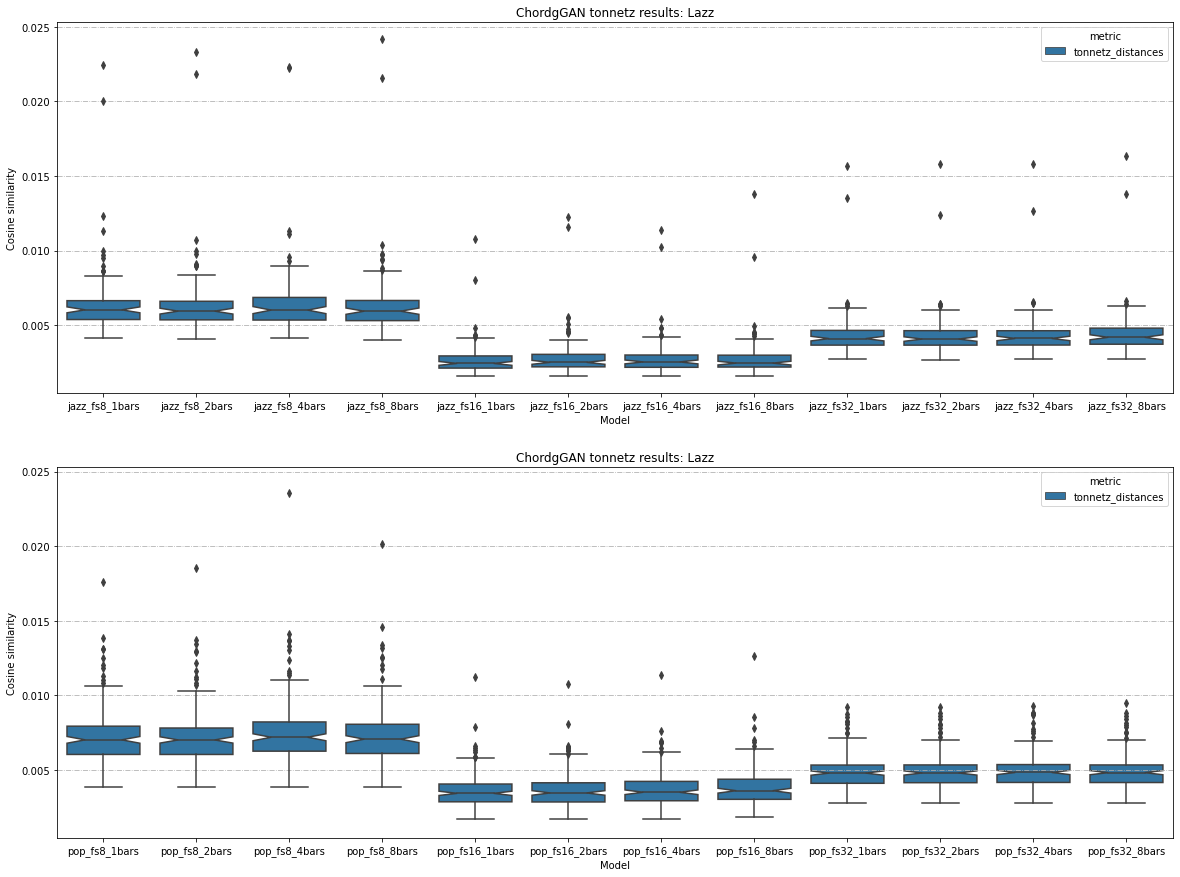

In [26]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 15), sharey=True)

tonnetz_jazz = tonnetz_df[tonnetz_df["model_name"].str.contains("jazz")]
tonnetz_pop = tonnetz_df[tonnetz_df["model_name"].str.contains("pop")]


ax1 = sns.boxplot(
    x="model_name", y="value", hue="metric", data=tonnetz_jazz, ax=ax1, notch=True
)
ax1.yaxis.grid(True, linestyle="-.")
ax1.set_title("ChordgGAN tonnetz results: Jazz")
ax1.set_xlabel("Model")
ax1.set_ylabel("Cosine similarity")

ax2 = sns.boxplot(
    x="model_name", y="value", hue="metric", data=tonnetz_pop, ax=ax2, notch=True
)
ax2.yaxis.grid(True, linestyle="-.")
ax2.set_title("ChordgGAN tonnetz results: Pop")
ax2.set_xlabel("Model")
ax2.set_ylabel("Cosine similarity")

plt.show()

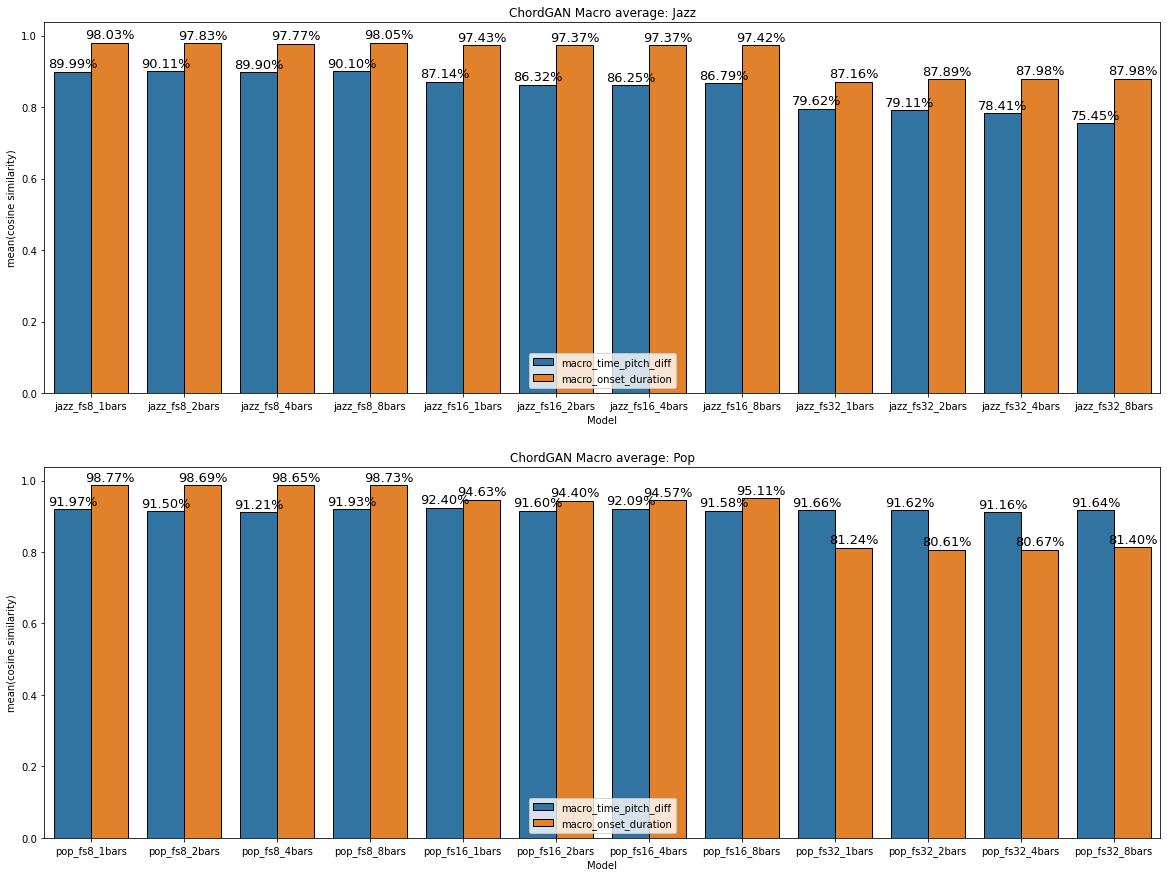

In [30]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 15), sharey=True)

macro_jazz = macro_df[macro_df["model_name"].str.contains("jazz")]
macro_pop = macro_df[macro_df["model_name"].str.contains("pop")]


ax1 = sns.barplot(
    x="model_name", y="value", hue="metric", data=macro_jazz, ec="k", lw=1, ax=ax1
)
autolabel(ax1, orient="v", fmt="{:.2%}", xytext=(1, 1), size=13)
ax1.legend(loc="lower center")
ax1.set_title("ChordGAN Macro average: Jazz")
ax1.set_xlabel("Model")
ax1.set_ylabel("mean(cosine similarity)")

ax2 = sns.barplot(
    x="model_name", y="value", hue="metric", data=macro_pop, ec="k", lw=1, ax=ax2
)
autolabel(ax2, orient="v", fmt="{:.2%}", xytext=(1, 1), size=13)
ax2.legend(loc="lower center")
ax2.set_title("ChordGAN Macro average: Pop")
ax2.set_xlabel("Model")
ax2.set_ylabel("mean(cosine similarity)")

plt.show()